In [375]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import os
import pandas as pd
from pathlib import Path
import pickle
from scipy.signal import welch, stft, spectrogram
from scipy.stats import wasserstein_distance, energy_distance
from tqdm import tqdm

In [376]:
# Load PSD baseline
while True:
    entry = input("Enter absolute path to your baseline PSD: ").strip().strip('"')
    try:
        baseline_psd_path = Path(entry)
    except ValueError:
        print("Invalid path format. Please enter a valid absolute path.")
        continue

    if baseline_psd_path.suffix == '.csv' and baseline_psd_path.is_file():  # Check if the path exists and ends with .csv
        print(f"Loading PSD from {entry}...")
        break
    else:
        print(f"Path '{entry}' does not exist. Please try again.")

# Load the PSD to compare against
while True:
    entry = input("Enter absolute path to your PSD to compare: ").strip().strip('"')
    try:
        comparison_psd_path = Path(entry)
    except ValueError:
        print("Invalid path format. Please enter a valid absolute path.")
        continue

    if comparison_psd_path.suffix == '.csv' and comparison_psd_path.is_file():  # Check if the path exists and ends with .csv
        print(f"Loading PSD from {entry}...")
        break
    else:
        print(f"Path '{entry}' does not exist. Please try again.")


Loading PSD from C:\Users\sapierso\Box\PD-Acoustic Project Data\0_FormattedData\PD-acoustic209\saved_psd_1_10_nperseg_16384.csv...
Loading PSD from C:\Users\sapierso\Box\PD-Acoustic Project Data\0_FormattedData\PD-acoustic209\saved_psd_1_10_nperseg_16384.csv...


In [ ]:
import re

def parse_trailing_number(s):
    # This regex says:
    #   ^       : start of string
    #   ([^\d]+): one or more non-digit characters → group 1 (the “prefix”)
    #   (\d+(?:\.\d+)?)$ 
    #            : one or more digits, optionally a decimal-point + more digits, 
    #              anchored at the end → group 2 (the “number”)
    m = re.match(r'^([^\d]+)(\d+(?:\.\d+)?)$', s)
    if not m:
        return None, None
    prefix, num_str = m.groups()
    num = float(num_str)
    return prefix, num

def psd_distance(f, P1, P2, f_min=1e3, f_max=50e3, metric='rmsle'):
    # 1) mask to band
    mask = (f >= f_min) & (f <= f_max)
    p1, p2 = P1[mask], P2[mask]
    f_masked = f[mask]
    eps = 0

    prefix, p = parse_trailing_number(metric)

    if metric == 'rmsle':
        return np.sqrt(np.mean((np.log(p1 + eps) - np.log(p2 + eps))**2))

    elif metric == 'skl':
        # symmetric KL divergence on normalized PSDs
        p1n, p2n = p1 / p1.sum(), p2 / p2.sum()
        return 0.5 * (
            np.sum(p1n * np.log(p1n / p2n)) +
            np.sum(p2n * np.log(p2n / p1n))
        )

    elif metric == 'angle':
        # spectral angle
        return np.arccos(np.dot(p1, p2) /
                         (np.linalg.norm(p1) * np.linalg.norm(p2)))
    
    elif metric == 'energy':
        # Energy distance
        return energy_distance(p1, p2)
    
    elif metric == 'L_inf':
        # L-infinity (Chebyshev) distance
        return np.max(np.abs(p1 - p2))
    
    elif prefix == 'L':
        # L8 distance (max norm)
        return np.max(np.abs(p1 - p2)**p)**(1/p)

    elif metric in ('emd', 'wasserstein'):
        # Earth Mover's (1-Wasserstein) distance
        return wasserstein_distance(
            f_masked,      # support for P1
            f_masked,      # support for P2 (same grid)
            u_weights=p1,  # masses for P1
            v_weights=p2   # masses for P2
        )

    elif metric in ('euclidean'):
        # Euclidean distance between the two PSDs
        return np.linalg.norm(p1 - p2)

    else:
        raise ValueError(f"Unknown metric '{metric}'")

RMSLE distance: 0.0
SKL distance: 0.0
Angle distance: 1.4901161193847656e-08
EMD distance: 0.0
L2 distance: 0.0


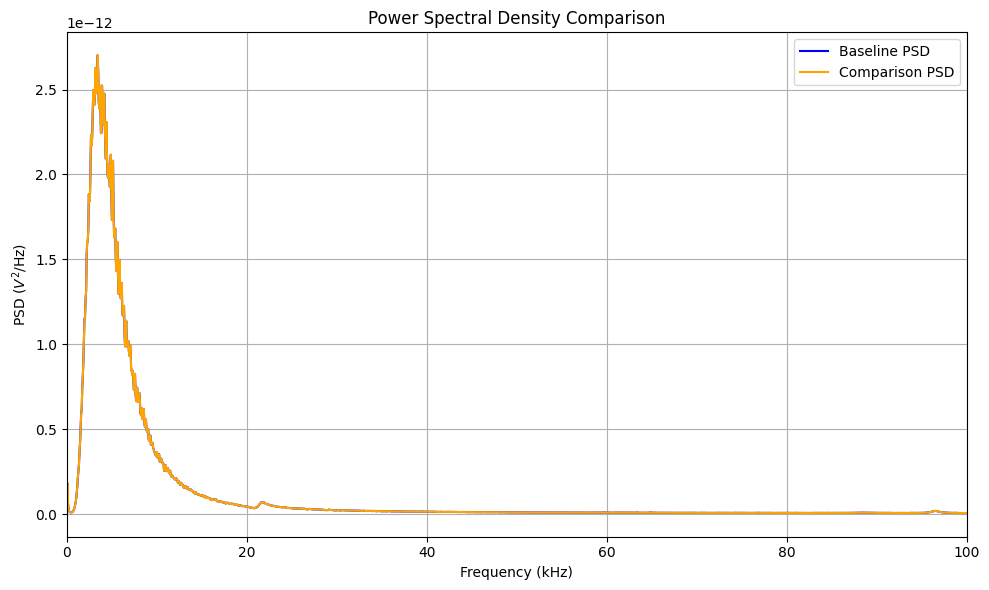

In [378]:
# 2) Read each CSV and collect PSD arrays
baseline_psd = pd.read_csv(baseline_psd_path)
baseline_freqs   = baseline_psd.iloc[:, 0].values
baseline_psd_vals= baseline_psd.iloc[:, 1].values
baseline_psd_vals_log = 10 * np.log10(baseline_psd_vals)

comparison_psd = pd.read_csv(comparison_psd_path)
comparison_freqs   = comparison_psd.iloc[:, 0].values
comparison_psd_vals= comparison_psd.iloc[:, 1].values
comparison_psd_vals_log = 10 * np.log10(comparison_psd_vals)

# 3) Calculate the distance
rmsle_distance = psd_distance(comparison_freqs, baseline_psd_vals, comparison_psd_vals, f_min=1e3, f_max=50e3, metric='rmsle')
skl_distance = psd_distance(comparison_freqs, baseline_psd_vals, comparison_psd_vals, f_min=1e3, f_max=50e3, metric='skl')
angle_distance = psd_distance(comparison_freqs, baseline_psd_vals, comparison_psd_vals, f_min=1e3, f_max=50e3, metric='angle')
emd_distance = psd_distance(comparison_freqs, baseline_psd_vals, comparison_psd_vals, f_min=1e3, f_max=50e3, metric='emd')
l2_distance = psd_distance(comparison_freqs, baseline_psd_vals, comparison_psd_vals, f_min=1e3, f_max=50e3, metric='euclidean')

# 4) Print the results
print(f"RMSLE distance: {rmsle_distance}")
print(f"SKL distance: {skl_distance}")
print(f"Angle distance: {angle_distance}")
print(f"EMD distance: {emd_distance}")
print(f"L2 distance: {l2_distance}")

# 5) Plot the PSDs
plt.figure(figsize=(10, 6))
plt.plot(baseline_freqs/1e3, baseline_psd_vals, label='Baseline PSD', color='blue')
plt.plot(comparison_freqs/1e3, comparison_psd_vals, label='Comparison PSD', color='orange')
plt.xlim(0, 100)
plt.xlabel('Frequency (kHz)')
plt.ylabel('PSD ($V^2$/Hz)')
plt.title('Power Spectral Density Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [379]:
def calculate_rms_from_psd(frequencies, psd_values, f_min=None, f_max=None):
    """
    Calculate RMS from PSD data over a specified frequency range.
    
    Parameters:
    frequencies: array of frequency values (Hz)
    psd_values: array of PSD values (V²/Hz or similar)
    f_min, f_max: frequency range for integration (optional)
    
    Returns:
    rms_value: RMS value in the same units as sqrt(PSD units)
    """
    # Apply frequency mask if limits are specified
    if f_min is not None or f_max is not None:
        f_min = f_min or frequencies.min()
        f_max = f_max or frequencies.max()
        mask = (frequencies >= f_min) & (frequencies <= f_max)
        freqs = frequencies[mask]
        psd = psd_values[mask]
    else:
        freqs = frequencies
        psd = psd_values
    
    # Calculate frequency spacing (assuming uniform spacing)
    df = freqs[1] - freqs[0]
    
    # Integrate PSD and take square root
    rms_value = np.sqrt(np.sum(psd * df))
    
    return rms_value

# Add this after loading your PSD data:
baseline_rms = calculate_rms_from_psd(baseline_freqs, baseline_psd_vals)
comparison_rms = calculate_rms_from_psd(comparison_freqs, comparison_psd_vals)

# Or calculate RMS over the same frequency band as your distance metrics:
baseline_rms_band = calculate_rms_from_psd(baseline_freqs, baseline_psd_vals, f_min=1e3, f_max=50e3)
comparison_rms_band = calculate_rms_from_psd(comparison_freqs, comparison_psd_vals, f_min=1e3, f_max=50e3)

print(f"Baseline RMS (full spectrum): {baseline_rms}")
print(f"Comparison RMS (full spectrum): {comparison_rms}")
print(f"Baseline RMS (1-50 kHz): {baseline_rms_band}")
print(f"Comparison RMS (1-50 kHz): {comparison_rms_band}")

Baseline RMS (full spectrum): 0.00012395238690633345
Comparison RMS (full spectrum): 0.00012395238690633345
Baseline RMS (1-50 kHz): 0.00011566156835227132
Comparison RMS (1-50 kHz): 0.00011566156835227132


### Load EasyAE Streamed Waveforms

In [380]:
# Ask for folder_path
while True:
    folder_path = input("Enter the absolute path to waveforms …").strip()
    if os.path.isdir(folder_path):
        break
    print("Invalid directory. Try again.")

print(f"Using folder: \"{folder_path}\"")

Using folder: "C:\Users\sapierso\Box\PD-Acoustic Project Data\0_FormattedData\PD-acoustic209\PD-acoustic209_wfms"


In [381]:
# Build & sort CSV-file list up front
def sort_key(fn):
    base = os.path.splitext(fn)[0]
    parts = base.split('_')
    try:
        return int(parts[-2])
    except:
        return 0

csv_files = sorted(
    [f for f in os.listdir(folder_path) if f.lower().endswith('.csv')],
    key=sort_key
)

# Try loading the pickle, otherwise build & cache
base_name     = os.path.basename(folder_path)
pickle_file   = os.path.join(folder_path, base_name + '_combined.pkl')

if os.path.isfile(pickle_file):
    print("Loading cached array…")
    with open(pickle_file, 'rb') as pf:
        loaded_item = pickle.load(pf)

    if isinstance(loaded_item, dict):
        # already in the new format
        combined_data      = loaded_item['combined_data']
        sample_interval    = loaded_item['sample_interval']
        stream_start_time  = loaded_item['start_time']
        wfm_stream_metadata = {
            'combined_data': combined_data,
            'sample_interval': sample_interval,
            'start_time': stream_start_time,
        }

    elif isinstance(loaded_item, np.ndarray):
        # --- NEW: bring the old array forward into the new-dict format ---
        combined_data = loaded_item

        if csv_files:
            # re-extract sample_interval & start_time from first CSV
            first_csv = os.path.join(folder_path, csv_files[0])
            with open(first_csv, 'r') as f:
                header = [next(f) for _ in range(12)]
            sample_interval = float(header[3].split(':')[-1].strip())
            stream_start_time_str = header[2].split(' ')[-1].strip()
            stream_start_time = datetime.strptime(stream_start_time_str, "%H:%M:%S")
        else:
            # If no CSV files, set defaults
            sample_interval = 1e-6  # Default to 1 microsecond
            # stream_start_time = mistras_metadata['start_time']  # Default to time from Mistras metadata  # TODO: Implement this if Mistras metadata is available

        # build the dict
        wfm_stream_metadata = {
            'combined_data': combined_data,
            'sample_interval': sample_interval,
            'start_time': stream_start_time,
        }

        # save it right back
        print("Upgrading pickle to new format…")
        with open(pickle_file, 'wb') as pf:
            pickle.dump(wfm_stream_metadata, pf)
        print("Re‐saved pickle with metadata.")
else:
    # Always pull sample_interval from first csv file
    first_csv = os.path.join(folder_path, csv_files[0])
    with open(first_csv, 'r') as f:
        header = [next(f) for _ in range(12)]
    sample_interval = float(header[3].split(':')[-1].strip())
    print("Sample interval (s):", sample_interval)
    stream_start_time_str = header[2].split(' ')[-1].strip()
    stream_start_time = datetime.strptime(stream_start_time_str, "%H:%M:%S")
    print("Stream start time:", stream_start_time)
    wfm_stream_metadata = {
        'sample_interval': sample_interval,
        'start_time': stream_start_time,
    }

    data_list = []
    for fn in tqdm(csv_files, desc="Reading CSVs"):
        path = os.path.join(folder_path, fn)
        arr  = np.loadtxt(path, delimiter=',', skiprows=12)
        data_list.append(arr)
    combined_data = np.vstack(data_list)
    wfm_stream_metadata['combined_data'] = combined_data
    print("Saving cache…")
    with open(pickle_file, 'wb') as pf:
        pickle.dump(wfm_stream_metadata, pf)

print("combined_data shape:", combined_data.shape)

sampling_frequency = 1 / sample_interval

Loading cached array…
combined_data shape: (133069141, 2)


In [382]:
start_time = 0
end_time = None

if end_time is not None:
    mask = (combined_data[:, 0] >= start_time) & (combined_data[:, 0] < end_time)
else:
    mask = (combined_data[:, 0] >= start_time)

masked_ae_data = combined_data[mask]

In [383]:
def compute_windowed_welch_with_progress(data, fs, window_sec, overlap_frac=0.5, nfft=None):
    # convert to samples
    win_len = int(window_sec * fs)
    noverlap = int(win_len * overlap_frac)
    if nfft is None:
        nfft = 1 << (win_len - 1).bit_length()

    # strided windows
    step = win_len - noverlap
    windows = sliding_window_view(data, win_len)[::step]

    psd_list = []
    for w in tqdm(windows, desc="Windowed Welch", unit="win"):
        f, Pxx = welch(
            w,
            fs=fs,
            nperseg=4096*4,
        )
        psd_list.append(Pxx)

    print(windows.shape)

    # stack into 2D array
    psd_array = np.vstack(psd_list)  # shape (n_windows, n_freqs)

    # now convert each PSD to dB scale, keeping original list intact
    psd_db_list = [10 * np.log10(psd) for psd in psd_list]

    # if you want a 2D array of dB-PSDs too:
    psd_db_array = np.vstack(psd_db_list)

    step = win_len - noverlap
    start_sample_indices = np.arange(0, len(data) - win_len + 1, step)
    times = start_sample_indices / fs + window_sec/2 # Center time of each Welch window start (in seconds)
    windows = sliding_window_view(data, win_len)[::step]

    # return frequencies, linear PSDs, and dB PSDs
    return f, psd_array, psd_db_array, times

# --- usage example ---
window_sec = 1.0  # window length (seconds)

if __name__ == "__main__":
    data = masked_ae_data[:, 1]
    fs = 1e6  # 1 MHz
    freqs, psds, psd_db, times = compute_windowed_welch_with_progress(
        data, fs, window_sec=window_sec
    )
    print("psd_db array shape:", psd_db.shape)

if np.isnan(psd_db).any():
    print("Warning: psd_db contains NaN values. This may indicate an issue with the PSD calculation.")

Windowed Welch: 100%|██████████| 265/265 [00:09<00:00, 26.53win/s]

(265, 1000000)
psd_db array shape: (265, 8193)


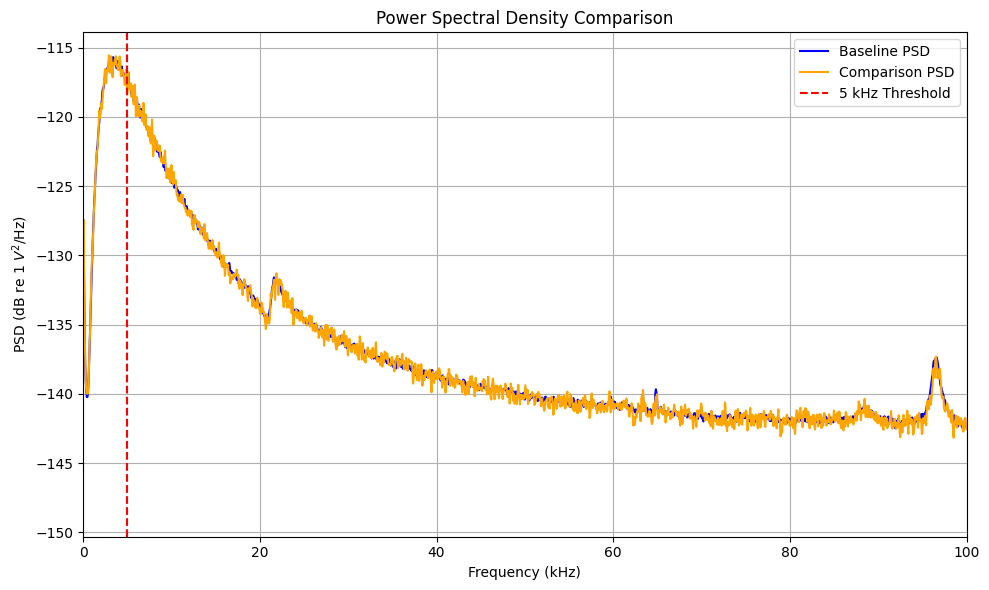

In [384]:
# 5) Plot the PSDs
plt.figure(figsize=(10, 6))
plt.plot(baseline_freqs/1e3, 10*np.log10(baseline_psd_vals), label='Baseline PSD', color='blue')
plt.plot(freqs/1e3, psd_db[1, :], label='Comparison PSD', color='orange')
plt.axvline(5, color='red', linestyle='--', label='5 kHz Threshold')
plt.xlim(0, 100)
plt.xlabel('Frequency (kHz)')
plt.ylabel('PSD (dB re 1 $V^2$/Hz)')
plt.title('Power Spectral Density Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

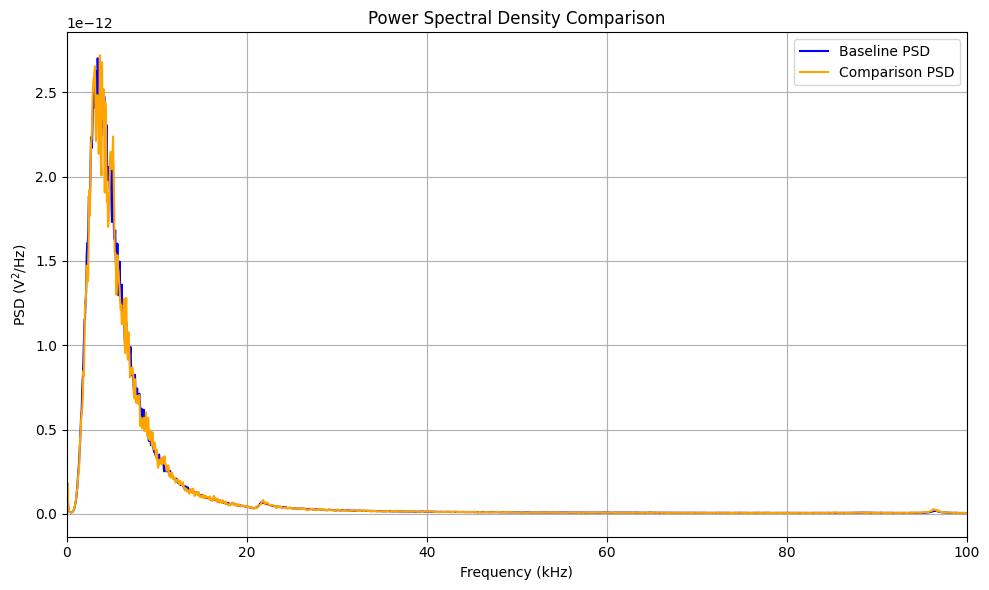

In [385]:
# 5) Plot the PSDs
plt.figure(figsize=(10, 6))
plt.plot(baseline_freqs/1e3, baseline_psd_vals, label='Baseline PSD', color='blue')
plt.plot(freqs/1e3, psds[40, :], label='Comparison PSD', color='orange')
plt.xlim(0, 100)
plt.xlabel('Frequency (kHz)')
plt.ylabel('PSD (V$^2$/Hz)')
plt.title('Power Spectral Density Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [386]:
print(psd_db.shape)
print(psd_db.shape[0])

(265, 8193)
265


In [387]:
# Iterate through the PSDs the spectrogram is comprised of and build an array of distances
rmsle_psd_distances = []
skl_psd_distances = []
angle_psd_distances = []
energy_psd_distances = []
L_inf_psd_distances = []
L_8_psd_distances = []
L_16_psd_distances = []
emd_psd_distances = []
euclidean_psd_distances = []

for i in tqdm(range(psds.shape[0]), desc="Calculating distances"):
    comparison_psd_vals = psds[i, :]
    comparison_psd_vals_log = 10 * np.log10(comparison_psd_vals)
    # psd_distance_value = psd_distance(baseline_freqs, baseline_psd_vals_log, comparison_psd_vals_log,
    #                                   f_min=1e3, f_max=50e3, metric='rmsle')
    # rmsle_psd_distances.append(psd_distance_value)
    skl_distance_value = psd_distance(baseline_freqs, baseline_psd_vals_log, comparison_psd_vals_log,
                                      f_min=1e3, f_max=50e3, metric='skl')
    skl_psd_distances.append(skl_distance_value)
    angle_distance_value = psd_distance(baseline_freqs, baseline_psd_vals_log, comparison_psd_vals_log,
                                        f_min=1e3, f_max=50e3, metric='angle')
    angle_psd_distances.append(angle_distance_value)
    energy_distance_value = psd_distance(baseline_freqs, baseline_psd_vals_log, comparison_psd_vals_log,
                                        f_min=1e3, f_max=50e3, metric='energy')
    energy_psd_distances.append(energy_distance_value)
    L_inf_distance_value = psd_distance(baseline_freqs, baseline_psd_vals_log, comparison_psd_vals_log,
                                        f_min=1e3, f_max=50e3, metric='L_inf')
    L_inf_psd_distances.append(L_inf_distance_value)
    L_8_distance_value = psd_distance(baseline_freqs, baseline_psd_vals_log, comparison_psd_vals_log,
                                      f_min=1e3, f_max=50e3, metric='L8')
    L_8_psd_distances.append(L_8_distance_value)
    L_16_distance_value = psd_distance(baseline_freqs, baseline_psd_vals_log, comparison_psd_vals_log,
                                      f_min=1e3, f_max=50e3, metric='L16')
    L_16_psd_distances.append(L_16_distance_value)
    # emd_distance_value = psd_distance(baseline_freqs, baseline_psd_vals_log, comparison_psd_vals_log,
    #                                   f_min=1e3, f_max=50e3, metric='emd')
    # emd_psd_distances.append(emd_distance_value)
    euclidean_distance_value = psd_distance(baseline_freqs, baseline_psd_vals_log, comparison_psd_vals_log,
                                      f_min=1e3, f_max=50e3, metric='euclidean')
    euclidean_psd_distances.append(euclidean_distance_value)
                              
# def psd_distance(f, P1, P2, f_min=1e3, f_max=50e3, metric='rmsle'):
#     # 1) mask to band
#     mask = (f>=f_min)&(f<=f_max)
#     p1, p2 = P1[mask], P2[mask]
#     eps = 0
#     if metric=='rmsle':
#         return np.sqrt(np.mean((np.log(p1+eps)-np.log(p2+eps))**2))
#     elif metric=='skl':
#         # normalize
#         p1n, p2n = p1/p1.sum(), p2/p2.sum()
#         return 0.5*(np.sum(p1n*np.log(p1n/p2n)) + np.sum(p2n*np.log(p2n/p1n)))
#     elif metric=='angle':
#         return np.arccos(np.dot(p1,p2)/(np.linalg.norm(p1)*np.linalg.norm(p2)))
#     # …and so on …

Calculating distances: 100%|██████████| 265/265 [00:00<00:00, 2680.98it/s]

Calculating L8.0 distance
Calculating L16.0 distance
Calculating L8.0 distance
Calculating L16.0 distance
Calculating L8.0 distance
Calculating L16.0 distance
Calculating L8.0 distance
Calculating L16.0 distance
Calculating L8.0 distance
Calculating L16.0 distance
Calculating L8.0 distance
Calculating L16.0 distance
Calculating L8.0 distance
Calculating L16.0 distance
Calculating L8.0 distance
Calculating L16.0 distance
Calculating L8.0 distance
Calculating L16.0 distance
Calculating L8.0 distance
Calculating L16.0 distance
Calculating L8.0 distance
Calculating L16.0 distance
Calculating L8.0 distance
Calculating L16.0 distance
Calculating L8.0 distance
Calculating L16.0 distance
Calculating L8.0 distance
Calculating L16.0 distance
Calculating L8.0 distance
Calculating L16.0 distance
Calculating L8.0 distance
Calculating L16.0 distance
Calculating L8.0 distance
Calculating L16.0 distance
Calculating L8.0 distance
Calculating L16.0 distance
Calculating L8.0 distance
Calculating L16.0 di

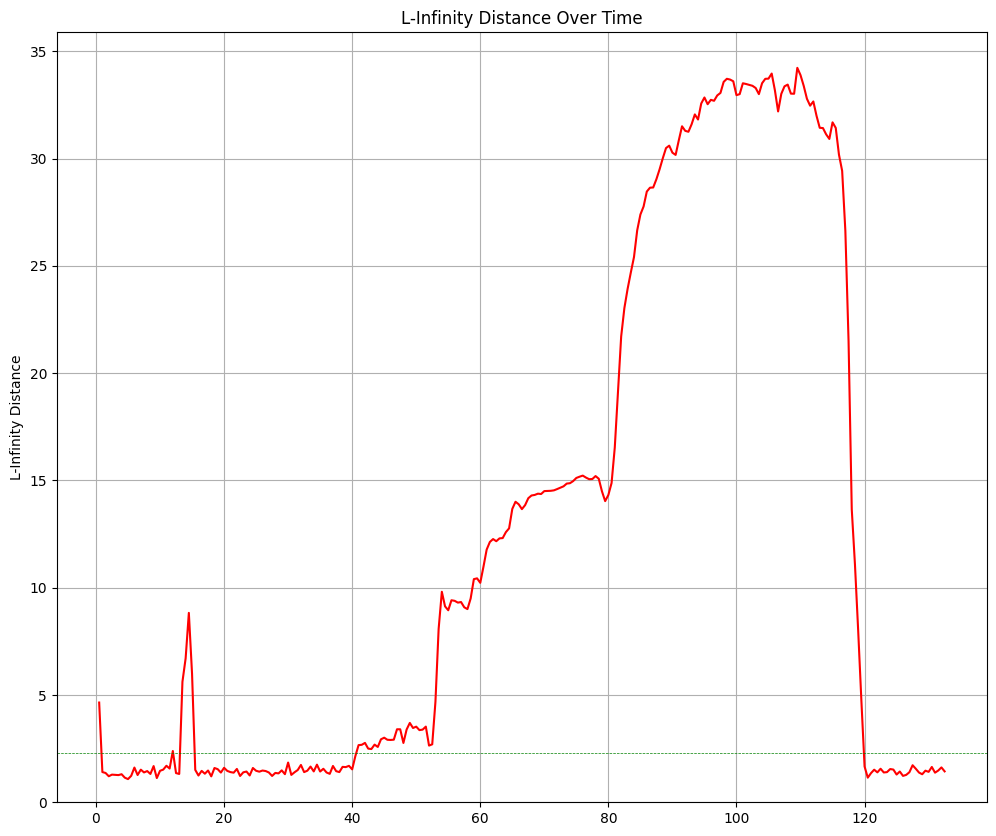

In [388]:
fig = plt.figure(figsize=(12, 10))
plt.plot(times, L_inf_psd_distances, color='red', label="L-Infinity Distance")
plt.ylabel("L-Infinity Distance")
plt.title("L-Infinity Distance Over Time")
plt.grid(True)
plt.ylim(bottom=0)       # force y‐axis bottom at 0

plt.axhline(y=2.3, color='green', linestyle='--', linewidth=0.5)  # Add a horizontal line at y=0

plt.show()

In [389]:
print(len(skl_psd_distances))
print(skl_psd_distances)

265
[1.0267454014820207e-05, 4.445450147759111e-06, 4.210582977339643e-06, 4.163613100032357e-06, 4.20065387306375e-06, 4.208302040378329e-06, 3.937570735094788e-06, 4.132028440200045e-06, 4.140848087562835e-06, 4.317698205974342e-06, 4.265046456231088e-06, 4.374166473564232e-06, 3.942993233181855e-06, 4.1943782770815785e-06, 4.467851481665185e-06, 4.383173208394019e-06, 4.538639540754898e-06, 4.241463326769491e-06, 3.848760972009765e-06, 4.496062497608758e-06, 5.074448717845493e-06, 5.095748464602199e-06, 5.633077019157082e-06, 5.59173331322782e-06, 5.023007113399106e-06, 4.941013642970628e-06, 1.3387217207575072e-05, 1.8053833972254832e-05, 1.348274596697194e-05, 8.301604094471332e-06, 5.29205678189943e-06, 5.117123955088868e-06, 4.969753893988916e-06, 5.0538263467381836e-06, 4.931172916134864e-06, 5.157341410536579e-06, 5.775765097570061e-06, 5.5253465926109165e-06, 5.06534990746867e-06, 5.0344993163189565e-06, 4.729161005938462e-06, 5.036683236355361e-06, 5.29509968517395e-06, 4.75

In [390]:
# Compute the spectrogram
spec_frequencies, spec_times, Sxx = spectrogram(masked_ae_data[:, 1], sampling_frequency, nperseg=4096*4)
Sxx_log = 10 * np.log10(Sxx)

max_freq = 50e3  # Frequency (Hz) over which to mask out the y-axis

freq_mask = spec_frequencies <= max_freq
masked_frequencies = spec_frequencies[freq_mask]
masked_Sxx_log = Sxx_log[freq_mask, :]

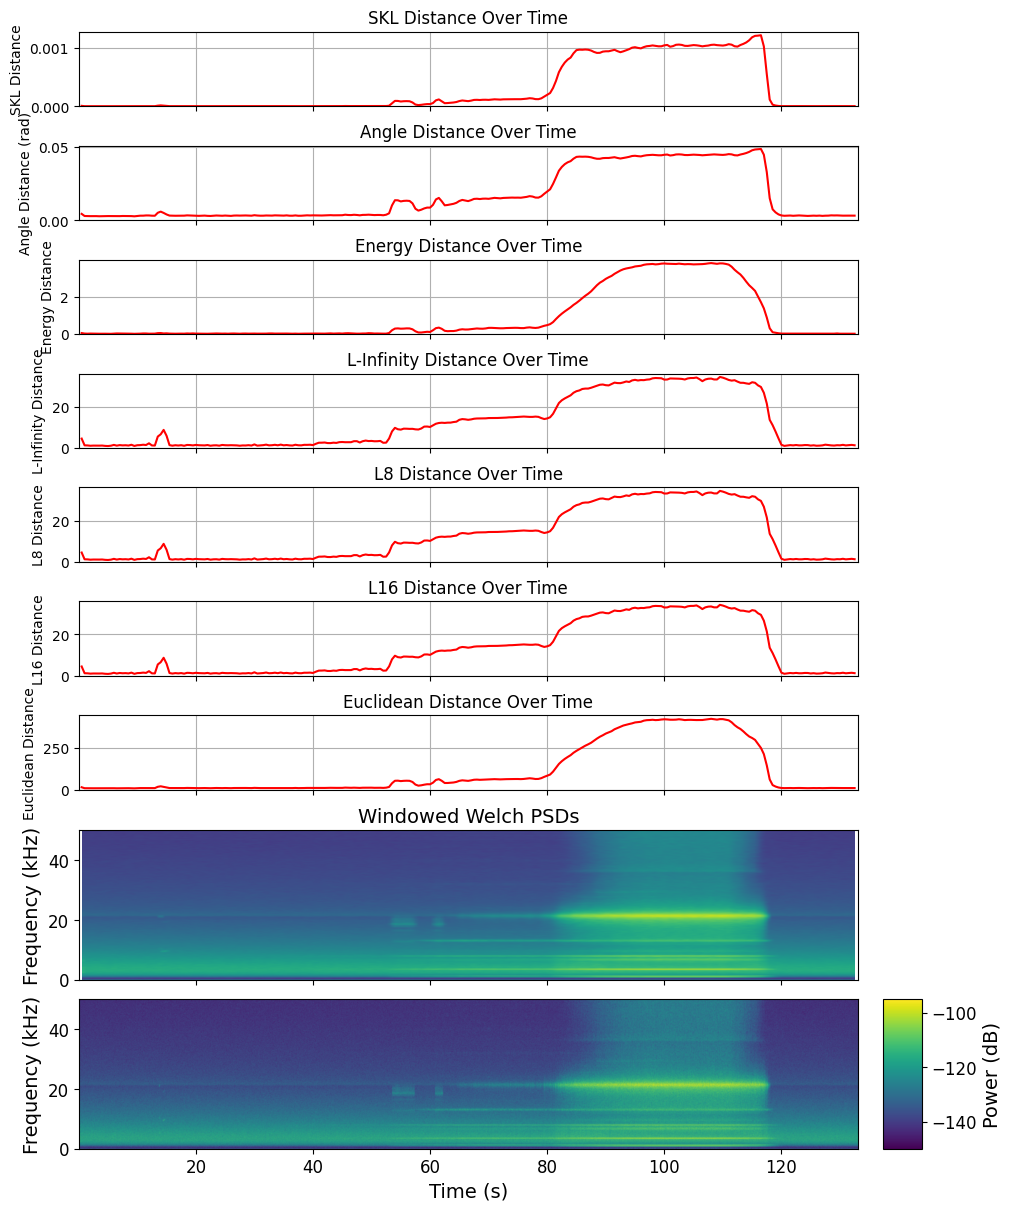

In [391]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

xmin, xmax = spec_times[0], spec_times[-1]
min_spec, max_spec = -150, -95

# line‐plot definitions
plots = [
    # (rmsle_psd_distances, 'RMSLE Distance',       'RMSLE Distance Over Time'),
    (skl_psd_distances,   'SKL Distance',         'SKL Distance Over Time'),
    (angle_psd_distances, 'Angle Distance (rad)', 'Angle Distance Over Time'),
    (energy_psd_distances,'Energy Distance',      'Energy Distance Over Time'),
    (L_inf_psd_distances, 'L-Infinity Distance', 'L-Infinity Distance Over Time'),
    (L_8_psd_distances,   'L8 Distance',         'L8 Distance Over Time'),
    (L_16_psd_distances,  'L16 Distance',        'L16 Distance Over Time'),
    # (emd_psd_distances,   'EMD Distance',         'EMD Distance Over Time'),
    (euclidean_psd_distances,    'Euclidean Distance',          'Euclidean Distance Over Time'),
]

# set up figure with 6 rows, 2 cols (2nd col for cbar), 
# making the bottom row taller for the spectrogram
fig = plt.figure(constrained_layout=True, figsize=(10, 12))
gs = gridspec.GridSpec(
    nrows=len(plots)+2, ncols=2, figure=fig,
    width_ratios=[20, 1],
    height_ratios=[1] * len(plots) + [2, 2],
    hspace=0.05, wspace=0.05
)

# create the top 5 rows of line plots
axes = []
for i, (data, ylabel, title) in enumerate(plots):
    # share x‐axis with the first subplot
    ax = fig.add_subplot(gs[i, 0], sharex=None if i == 0 else axes[0])
    log_data = np.log10(data)
    ax.plot(times, data, color='red', label=title)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)
    ax.set_ylim(bottom=0)       # force y‐axis bottom at 0
    ax.label_outer()            # hide inner tick‐labels (incl. x‐ticks on all but spectrogram)
    axes.append(ax)

####

# Filter frequencies for windowed Welch to match spectrogram frequency range
max_freq = 50e3
welch_freq_mask = freqs <= max_freq
masked_welch_freqs = freqs[welch_freq_mask]
masked_psd_db = psd_db[:, welch_freq_mask]

# Row 6: Windowed Welch PSDs as image
welch_ax = fig.add_subplot(gs[len(plots), 0], sharex=axes[0])
welch_img = welch_ax.imshow(
    masked_psd_db.T,  # Transpose to have frequency on y-axis
    extent=[times[0], times[-1], masked_welch_freqs[-1]/1e3, masked_welch_freqs[0]/1e3],
    interpolation='bilinear',
    cmap='viridis',
    aspect='auto',
    vmin=min_spec,
    vmax=max_spec
)
welch_ax.invert_yaxis()
welch_ax.set_ylabel('Frequency (kHz)', fontsize=14)
welch_ax.set_title('Windowed Welch PSDs', fontsize=14)
welch_ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.0f}'))
welch_ax.tick_params(axis='both', which='major', labelsize=12)
welch_ax.label_outer()  # Hide x-axis labels since spectrogram is below

####

# bottom row: spectrogram in column 0
spec_ax = fig.add_subplot(gs[len(plots)+1, 0], sharex=axes[0])
spec_img = spec_ax.imshow(
    masked_Sxx_log,
    extent=[xmin, xmax, masked_frequencies[-1]/1e3, masked_frequencies[0]/1e3],
    interpolation='bilinear',
    cmap='viridis',
    aspect='auto',
    vmin=min_spec,
    vmax=max_spec
)
spec_ax.invert_yaxis()
spec_ax.set_xlabel('Time (s)', fontsize=14)
spec_ax.set_ylabel('Frequency (kHz)', fontsize=14)
spec_ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.0f}'))
spec_ax.tick_params(axis='both', which='major', labelsize=12)

# bottom row: colorbar in column 1
cax = fig.add_subplot(gs[len(plots)+1, 1])
cbar = fig.colorbar(spec_img, cax=cax, orientation='vertical')
cbar.set_label('Power (dB)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.show()


In [392]:
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# import numpy as np
# import os

# # Dummy data for illustration (replace with your real data)
# # baseline_freqs, baseline_psd_vals, freqs, and psd_db must be defined before this

# fig, ax = plt.subplots(figsize=(10, 6))
# line1, = ax.plot(baseline_freqs / 1e3, 10 * np.log10(baseline_psd_vals), label='Baseline PSD', color='blue')
# line2, = ax.plot([], [], label='Comparison PSD', color='orange')

# ax.set_ylim(-150, -95)
# ax.set_xlim(0, 100)
# # ax.set_ylim(np.min(10 * np.log10(psd_db)), np.max(10 * np.log10(psd_db)))
# ax.set_xlabel('Frequency (kHz)')
# ax.set_ylabel('PSD (dB re 1 $V^2$/Hz)')
# ax.set_title('Power Spectral Density Comparison')
# ax.legend()
# ax.grid(True)
# plt.tight_layout()

# def update(frame):
#     # update the data
#     line2.set_data(freqs / 1e3, psd_db[frame, :])
#     # grab the corresponding time
#     t = times[frame]
#     # set the title to show time rather than frame number
#     ax.set_title(f'Power Spectral Density Comparison (t = {t:.3f} s)')
#     return line2,

# ani = animation.FuncAnimation(
#     fig, update, frames=range(psd_db.shape[0]), blit=True, interval=200
# )
# # Save the animation
# output_filename = 'psd_animation.mp4'
# ani.save(output_filename)

# # Print the absolute path
# full_path = os.path.abspath(output_filename)
# print(f"Animation saved to: {full_path}")

# plt.show()
